# DealInfos & Wepick_Setting 을 ES에 벌크 인서트

-  환경: ElasticSearch 6
-  테스트 머신: 장민 PC or twiceSpark1

```
- dealinfos (몽고디비 dealinfos 컬렉션), wepick_setting (wepick_setting.pkl) 적재
```

In [1]:
import requests
import time
import urllib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import json
import elasticsearch
import csv
import pickle
from elasticsearch.helpers import bulk
import re
import glob
import os
from datetime import timezone, timedelta, datetime
import pandas as pd

In [2]:
def make_documents(file_path):
    pred_dic = {}
    with open(file_path, 'rb') as jsonfile:
        for row in jsonfile:
            source = eval(row)
            source['sst'] = datetime.fromtimestamp(source['sst'])
            source['set'] = datetime.fromtimestamp(source['set'])
            source['dc'] = source['dc'].replace(" ", "") # 편의상 공백을 모두 지워버림
            doc =  {
                "_op_type":'create',
                "_index":"dealinfos",
                "_type":"doc",
                "_id": source['did'],
                "_source": source
            }
            yield(doc)

In [3]:
### Jangmin's PC
#es_url = 'localhost:9200'

es_url = 'twiceSpark1:9200'

In [4]:
es = elasticsearch.Elasticsearch(es_url)

In [5]:
es.indices.get_settings(index='dealinfos')

{'dealinfos': {'settings': {'index': {'analysis': {'analyzer': {'my_analyzer': {'filter': ['my_length_filter',
        'lowercase'],
       'tokenizer': 'my_tokenizer',
       'type': 'custom'},
      'my_analyzer_comma': {'filter': ['my_length_filter', 'lowercase'],
       'tokenizer': 'my_tokenizer_comma_only',
       'type': 'custom'}},
     'filter': {'my_length_filter': {'max': '20',
       'min': '2',
       'type': 'length'}},
     'tokenizer': {'my_tokenizer': {'pattern': '[,/]',
       'type': 'simple_pattern_split'},
      'my_tokenizer_comma_only': {'pattern': '[,]',
       'type': 'simple_pattern_split'}}},
    'creation_date': '1530536617370',
    'number_of_replicas': '1',
    'number_of_shards': '5',
    'provided_name': 'dealinfos',
    'uuid': '5PIhYaDLQeqrNekGHSkXPw',
    'version': {'created': '6030099'}}}}}

# bulk inserting to ES

In [6]:
# jangmin PC
data_dir = r'd:\WMIND\temp\dealinfo'
# for twiceSpark1
# r'/home/twice/ojm/dealinfo'
start = time.time()
total_time = 0
bulk(es, make_documents(data_dir))
total_time += (time.time() - start)
print("Elapsed Time {} sec".format(total_time))

Elapsed Time 6516.166028022766 sec


In [27]:
res = es.search(index='dealinfos', body={'query': {'match':{'dc':'에버랜드'}}})

## wepick_setting to ES

In [7]:
with open(r'wepick_setting.pkl', 'rb') as f:
    wepick_setting_dic = pickle.load(f)

In [23]:
def make_documents(wepick_setting_path):
    with open(wepick_setting_path, 'rb') as f:
        wepick_setting_dic = pickle.load(f)
        source= {}
        for dt, setting in wepick_setting_dic.items():
            source['dt'] = dt
            vec = []
            for slot, did in setting.items():
                vec.append("{}_{}".format(slot, did))
            source['setting'] = vec
            doc =  {
                "_op_type":'create',
                "_index":"wepick_setting",
                "_type":"doc",
                "_id": source['dt'],
                "_source": source
            }
            yield(doc)

In [24]:
#data_dir = r'd:\WMIND\temp\dealinfo_small'
data_dir = r'wepick_setting.pkl'
start = time.time()
total_time = 0
bulk(es, make_documents(data_dir))
total_time += (time.time() - start)
print("Elapsed Time {} sec".format(total_time))

Elapsed Time 0.900590181350708 sec


### wepick_setting to ES (확장 버전)

- 3월10일- 4월11일까지 전부

In [7]:
data_path = r'd:\WMIND\temp\wepick_settings.txt'

In [8]:
with open(data_path) as csvfile:
    reader = csv.reader(csvfile)
    wepick_setting_dic = {}
    for row in reader:
        deal_info = row[0].strip().split(' ')
        cnt, did = int(deal_info[0]), int(deal_info[1])
        slot = int(row[1])
        dt= row[2]
        if dt not in wepick_setting_dic:
            wepick_setting_dic[dt] = {}
        if slot not in wepick_setting_dic[dt] or cnt > wepick_setting_dic[dt][slot][1]:
            wepick_setting_dic[dt][slot] = (did, cnt)

In [9]:
def make_documents(wepick_setting_dic):        
        for dt, settings in wepick_setting_dic.items():
            source= {}
            source['dt'] = dt
            vec = []
            for slot, deal_info in settings.items():
                vec.append( {"slot":slot, "did":deal_info[0], "cnt":deal_info[1]} )
            source['settings'] = vec
            doc =  {
                "_op_type":'create',
                "_index":"wepick_setting_ext",
                "_type":"doc",
                "_id": source['dt'],
                "_source": source
            }
            yield(doc)

In [10]:
start = time.time()
total_time = 0
bulk(es, make_documents(wepick_setting_dic))
total_time += (time.time() - start)
print("Elapsed Time {} sec".format(total_time))

Elapsed Time 1.6316378116607666 sec


In [10]:
wepick_setting_dic['2018-04-11 23']

{1: (3527645, 4119),
 2: (3526222, 3422),
 3: (3524983, 833),
 4: (3521050, 3510),
 5: (3513020, 1443),
 6: (3515664, 3008),
 7: (3535398, 2821),
 9: (3526953, 864),
 10: (3525364, 2855),
 11: (3532655, 288),
 12: (3521622, 380),
 13: (3524754, 177),
 14: (3207879, 195),
 15: (3528037, 975),
 17: (2991058, 381),
 18: (3520987, 2013),
 19: (1534369, 262),
 20: (3527675, 1285),
 21: (3525346, 76),
 22: (3486081, 345),
 23: (2409745, 324),
 24: (3529131, 467),
 25: (3119538, 288),
 26: (3538332, 380),
 27: (3528363, 1506),
 28: (3525317, 1658),
 29: (3505573, 378),
 30: (3512215, 704),
 31: (3519047, 379),
 32: (3514459, 1032),
 33: (3541064, 186),
 34: (1438471, 288),
 35: (3515997, 1392),
 36: (3512593, 1486),
 37: (3068897, 247),
 38: (3525124, 155),
 39: (3517009, 610),
 40: (3544562, 675),
 41: (3539755, 574),
 42: (3526985, 1222),
 43: (3527053, 587),
 44: (3522402, 707),
 45: (3515524, 975),
 46: (3522395, 597),
 47: (3500355, 176),
 48: (3516354, 162),
 49: (3509649, 215),
 50: (3

### 간단 분석

In [31]:
## 간단 분석
path = 'c:\\windows\\fonts\\nanumgothiccoding.ttf'
font_name = fm.FontProperties(fname=path, size=50).get_name()
plt.rc('font', family=font_name)

In [53]:
h = []
label = []
for s, pair in dic['2018-04-11 16'].items():
    if s < 21: continue
    h.append(int(pair[1]))
    label.append(s)


In [119]:
slot_dic = {}
#for i in range(24):
for dt in dic.keys():
    #dt = '2018-04-10 {:02}'.format(i)
    for s, pair in dic[dt].items():
        if s > 100 or s < 20: continue
        if s not in slot_dic:
            slot_dic[s] = pair[1]
        else:
            slot_dic[s] += pair[1]

In [120]:
import numpy as np

In [121]:
n_groups = len(label)

In [122]:
plt.plot( slot_dic.keys(), slot_dic.values() )

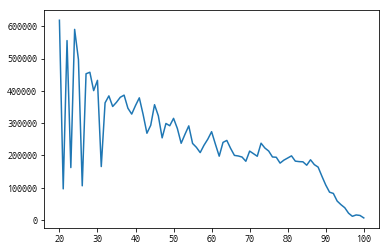

In [123]:
plt.show()

In [86]:
slot_dic

{21: 96344,
 22: 555880,
 23: 162338,
 24: 590638,
 25: 497122,
 26: 105804,
 27: 453021,
 28: 457793,
 29: 400802,
 30: 432653,
 31: 165501,
 32: 362986,
 33: 384490,
 34: 351675,
 35: 364683,
 36: 380245,
 37: 386812,
 38: 346335,
 39: 328041,
 40: 354587,
 41: 378463,
 42: 326872,
 43: 268729,
 44: 293436,
 45: 357237,
 46: 322691,
 47: 254410,
 48: 299000,
 49: 291971,
 50: 314874,
 51: 283494,
 52: 237638,
 53: 265361,
 54: 291537,
 55: 237128,
 56: 225087,
 57: 208740,
 58: 231501,
 59: 250360,
 60: 273493,
 61: 234818,
 62: 197651,
 63: 240403,
 64: 246465,
 65: 221687,
 66: 200070,
 67: 198304,
 68: 194979,
 69: 181843,
 70: 213362,
 71: 205468,
 72: 197385,
 73: 237838,
 74: 223019,
 75: 213612,
 76: 195124,
 77: 194301,
 78: 176141,
 79: 185387,
 80: 191943,
 81: 198641,
 82: 182312,
 83: 180791,
 84: 180220,
 85: 169651,
 86: 186484,
 87: 171513,
 88: 163740,
 89: 135349,
 90: 108277,
 91: 86088,
 92: 82180,
 93: 58596,
 94: 47415,
 95: 37902,
 96: 20890,
 97: 11280,
 98: 15

### Negative Labeling 전략

-  데이터: pos_dataset_by_user.csv
- ```
sort -t, -k2,2n -k4n pos_dataset.csv > pos_dataset_by_user.csv
```

In [11]:
data_path = r'd:\WMIND\temp\pos_dataset_by_user.csv'

In [12]:
def process_user(u, vec, wepick_setting_dic):
    print(u, vec)

In [25]:
with open(data_path) as csvfile:
    reader = csv.reader(csvfile)
    prev_u = None
    user_vec = []
    i = 0
    for row in reader:
        v,u,slot,rgtime,dt = row[0], row[1], row[2], pd.to_datetime(row[3], unit='ms', utc=True).tz_convert('Asia/Tokyo'), row[4]
        if prev_u != None and prev_u != u:
            process_user(prev_u, user_vec, wepick_setting_dic)
            user_vec = []
            i += 1
            if i == 3: break
        prev_u = u
        user_vec.append((v, slot, rgtime, dt))
    if user_vec != []:
        process_user(prev_u, user_vec)

1000006 [('3398131', '22', Timestamp('2018-03-11 20:54:36.608000+0900', tz='Asia/Tokyo'), '2018-03-11 20'), ('3365865', '5', Timestamp('2018-03-12 13:50:30.903000+0900', tz='Asia/Tokyo'), '2018-03-12 13'), ('3284877', '6', Timestamp('2018-03-12 13:50:51.361000+0900', tz='Asia/Tokyo'), '2018-03-12 13'), ('3384031', '9', Timestamp('2018-03-12 13:51:18.597000+0900', tz='Asia/Tokyo'), '2018-03-12 13'), ('3398754', '1', Timestamp('2018-03-12 13:53:37.854000+0900', tz='Asia/Tokyo'), '2018-03-12 13'), ('3387193', '2', Timestamp('2018-03-12 19:33:46.955000+0900', tz='Asia/Tokyo'), '2018-03-12 19'), ('3429250', '1', Timestamp('2018-03-18 23:40:18.543000+0900', tz='Asia/Tokyo'), '2018-03-18 23'), ('3337685', '10', Timestamp('2018-03-18 23:42:59.454000+0900', tz='Asia/Tokyo'), '2018-03-18 23'), ('3418856', '10', Timestamp('2018-03-20 19:28:20.613000+0900', tz='Asia/Tokyo'), '2018-03-20 19'), ('3339612', '7', Timestamp('2018-03-26 22:48:24.891000+0900', tz='Asia/Tokyo'), '2018-03-26 22'), ('193849

In [24]:
pd.to_datetime('1520769276608', unit='ms', utc=True).tz_convert('Asia/Tokyo')

Timestamp('2018-03-11 20:54:36.608000+0900', tz='Asia/Tokyo')